<div style="background-color: #ffffff; color: #000000; padding: 10px;">
<div style="display: flex; justify-content: space-between; align-items: center; background-color: #ffffff; color: #000000; padding: 10px;">
    <img src="../media/logo_kisz.png" height="80" style="margin-right: auto;" alt="Logo of the AI Service Center Berlin-Brandenburg.">
    <img src="../media/logo_bmbf.jpeg" height="150" style="margin-left: auto;" alt="Logo of the German Federal Ministry of Education and Research: Gefördert vom Bundesministerium für Bildung und Forschung.">
</div>
<h1> Video Search
<h2> Finding Locations in Audio and Video with Automatic Speech Recognition and Semantic Search
</div>

<div style="background-color: #f6a800; color: #ffffff; padding: 10px;">
    <h2> Part 1 - Introduction to Digital Signal Processing
</div>

Speech is the primary way humans communicate using **sound**. Speech is a **continuous signal** that unfolds over time and that is shaped by the movement of our articulatory organs such as the lips, tongue, and vocal cords.

From a physical perspective, spoken words are **pressure waves** that usually travel through the air. These sound waves vary in **frequency** (related to pitch) and **amplitude** (related to loudness). The complexity of these variations carries the rich information of human language.

To analyse and process speech computationally, we must convert these continuous acoustic signals into a form that reveals their structure. To this end, we use various processing techniques that are introduced in this notebook.

1. **Fast Fourier Transform (FFT)**: breaks down the signal into its frequency components
2. **Mel-frequency scaling**: scales the frequency components to the Mel-scale, which reflects how humans perceive pitch
3. **Filterbanks**: transform the signal into mel-frequency coefficients that represent the sound signal using short numerical vectors

Techniques of digital signal processing pave the way for training automated speech recognition models such as Whisper.

<div style="background-color: #dd6108; color: #ffffff; padding: 10px;">
<h3>1. Motivation - Deriving acoustic features for training LLMs
</div>

We start with an audio signal ...

In [1]:
import IPython.display as ipyd
import librosa

spectrogram, srSpectrogram = librosa.load("./data/spectrogram.wav", sr=None)
display(ipyd.Audio(data=spectrogram, rate=srSpectrogram))

... that is represented with a huge array ...

In [2]:
spectrogram.shape

(71552,)

and we transform it in such a way that we can represent the relevant information with few and smart acoustic features. For doing so, we use Mel-Frequency Cepstral Coefficients (MFCCs):

In [3]:
mfccs = librosa.feature.mfcc(y=spectrogram, sr=srSpectrogram, n_mfcc=13)
mfccs.shape

(13, 140)

Eventually, what the machine 'hears' sounds similar to this:

In [4]:
reconstructed_audio = librosa.feature.inverse.mfcc_to_audio(mfccs, sr=srSpectrogram)
ipyd.Audio(reconstructed_audio, rate=srSpectrogram)

This compressed audio preserves all the relevant information (we still understand the word) and consists of only 13 (!) dimensions. In addition, we have 140 columns, each representing the information of a different timepoint of the signal.

In what follows, this notebook explains the concepts underlying this compression. By doing so, it becomes clear that this compression is informed by how humans process speech.

<div style="background-color: #dd6108; color: #ffffff; padding: 10px;">
<h3>2. The Fast Fourier Transform (FFT)
</div>

The FFT is an algorithm that transforms the speech signal, consisting of multiple samples in the time domain, into its frequency components. For starters, let us understand a simple audio signal. It is defined by its frequency (how often the sound wave oscilated per second), its amplitude, its duration, and its sampling rate (i.e. how often per second samples are taken). The following code creates a 2-second signal with constant amplitude, a frequency of 400 Hertz and 16000 samples per second.

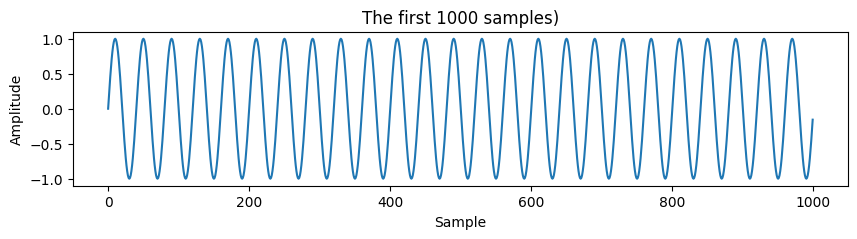

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate, visualise and play a sound with custom frequency and duration

def make_audio(duration=2, sampling_rate=16000, frequency=100, print=True):
    # Create the samples
    N = duration*sampling_rate # number of samples for given duration
    n = np.arange(N) # sample indices
    audio=np.sin(2*np.pi*(frequency/sampling_rate)*n) # generate sine wave

    # Visualise the first thousand samples
    if print:
        plt.figure(figsize=(10, 2))
        plt.plot(n[:1000], audio[:1000])
        plt.title("The first 1000 samples)")
        plt.xlabel("Sample")
        plt.ylabel("Amplitude")
        plt.show()

    # Play the sound
    return audio

# Customise the sound's parameters
duration = 2 # duration in seconds
sampling_rate = 16000 # sampling rate
frequency = 400 # frequency in Hertz (Hz)


# Generate, visualise and play the sound
audio = make_audio(duration=duration, sampling_rate=sampling_rate, frequency=frequency, print=True)
ipyd.Audio(rate=sampling_rate, data=audio)

The FFT is an algorithm that breaks down a signal into its constituent frequencies. A computational implementation of the FFT computes the Discrete Fourier Transform, which is defined as:

$$
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-2\pi i \frac{kn}{N}}
$$

where:

- $ X_k $ is the $ k $-th frequency component,
- $ x_n $ is the $ n $-th time-domain sample,
- $ N $ is the total number of samples,
- $ k = 0, 1, ..., N-1 $.

If we apply the FFT (or DFT) to our audio signal, we will see its frequency components. For applying the FFT, we need to specify an audio and its sampling rate.

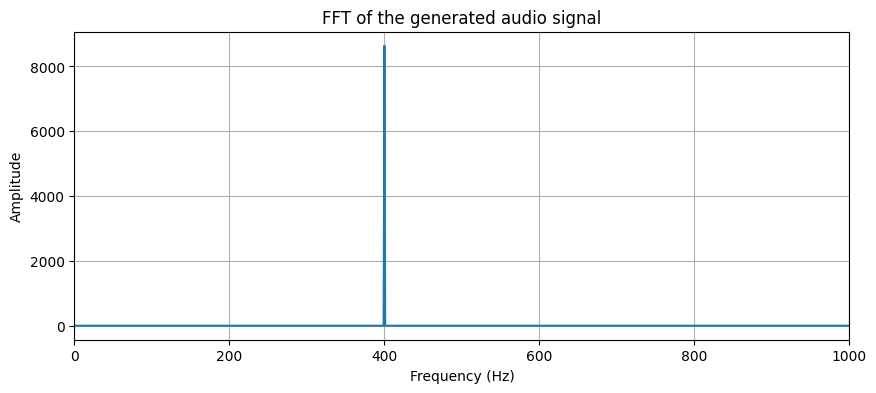

In [7]:
def apply_fft(audio, sampling_rate=16000, logscale=False, windowing=True):
    # Apply FFT
    N = len(audio)
    w = np.hamming(N)
    if windowing:
        audioFFT = np.fft.fft(audio*w)
    else:
        audioFFT = np.fft.fft(audio)
    
    # Plot spectrum
    plt.figure(figsize=(10, 4))
    if logscale:
        plt.plot(np.linspace(0, sampling_rate*(N - 1)/N, N), np.log(np.abs(audioFFT)))
    else:
        plt.plot(np.linspace(0, sampling_rate*(N - 1)/N, N), np.abs(audioFFT))
    plt.grid(True)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1000)
    
    return plt

plt = apply_fft(audio=audio, sampling_rate=sampling_rate, logscale=False, windowing=True)
plt.title("FFT of the generated audio signal")
plt.show()

<div style="background-color: #dd6108; color: #ffffff; padding: 10px;">
<h3>3. FFT Analysis of an A Minor Chord
</div>

In this section, we walk through a few examples, illustrating the nature of audio signals. First, we synthesise a A minor chord, which consists of the notes A (110 Hz, 220 Hz, 440 Hz etc. ), C (130.81 Hz, 261.63 Hz, 523.25 Hz, etc.), and E (164.81 Hz, 329.63 Hz, 659.25  Hz etc.). There are multiple frequencies for each note because notes can be playes in different octaves.

In [8]:
A_FQ = [110, 220, 440]
C_FQ = [130, 261, 523]
E_FQ = [164, 330, 659]

octave = 1

# synthesise the fate motif
A = make_audio(duration=2, sampling_rate=sampling_rate, frequency=A_FQ[octave], print=False)
C = make_audio(duration=2, sampling_rate=sampling_rate, frequency=C_FQ[octave], print=False)
E = make_audio(duration=2, sampling_rate=sampling_rate, frequency=E_FQ[octave], print=False)
AminorSynth = A + C + E
ipyd.Audio(rate=sampling_rate, data=AminorSynth)

The FFT helps us to break down the frequency content of the A minor chord.

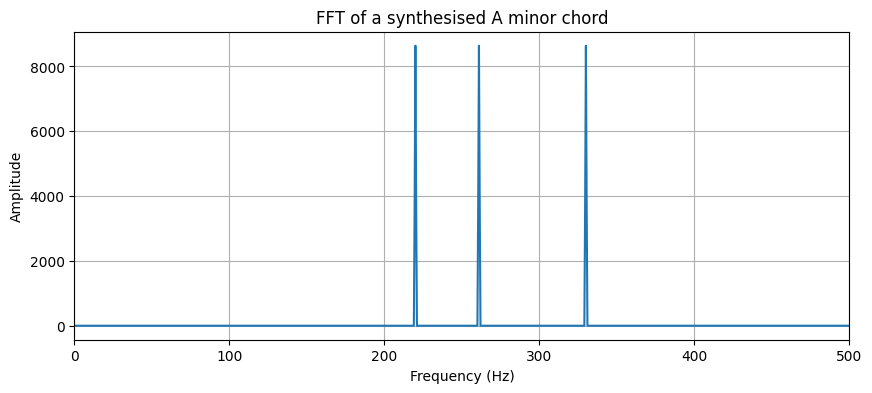

In [9]:
# investigate the A minor chord's frequency components.
plt = apply_fft(audio=AminorSynth, sampling_rate=sampling_rate)
plt.xlim(0, 500)
plt.title("FFT of a synthesised A minor chord")
plt.show()

However, natural sound is more complex than pure tones for a number of reasons:

1. In the context of music, instruments produce rich harmonic content. That is, a single note on an instrument produces a sine wave at its fundamental frequency (e.g., 110 Hz for A), but also at its overtones (e.g., 220 Hz, 440 Hz).
2. The environment produces reflections and filtering effects of specific frequencies.
3. Natural sounds have transient onsets, vibrato and natural fluctuations, which are especially important for speech sounds.

In [12]:
# load and play a recording from a guitar playing an A minor chord
naturalAminor, srNatural = librosa.load("./data/guitar_chord_a_minor.wav", sr=None)

# only keep audio from second 3 to 5
naturalAminor = naturalAminor[3*srNatural:5*srNatural]
ipyd.Audio(data=naturalAminor, rate=srNatural)

Applying the FFT to this natural recording reveals that there is indeed much more going on than in case of our synthetic A minor chord.

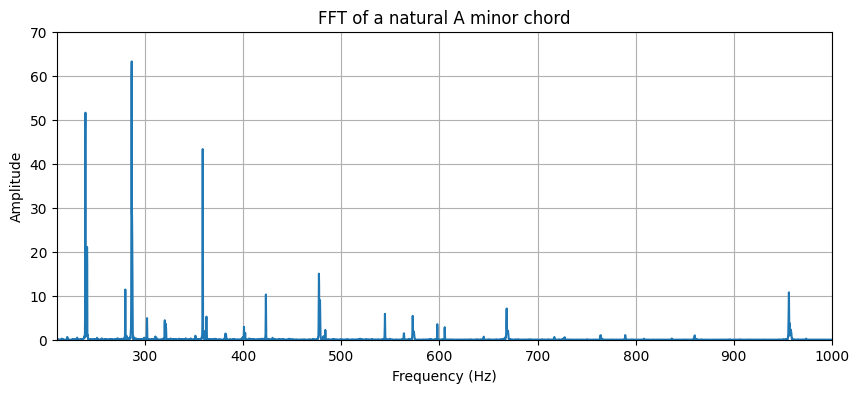

In [11]:
# visualise overtones
plt = apply_fft(audio=naturalAminor, sampling_rate=sampling_rate)
plt.xlim(210, 1000)
plt.ylim(0, 70)
plt.title("FFT of a natural A minor chord")
plt.show()

For instance, we can see that the guitar is in sharp tuning, that is, the observed frequencies are higher than the expected ones.

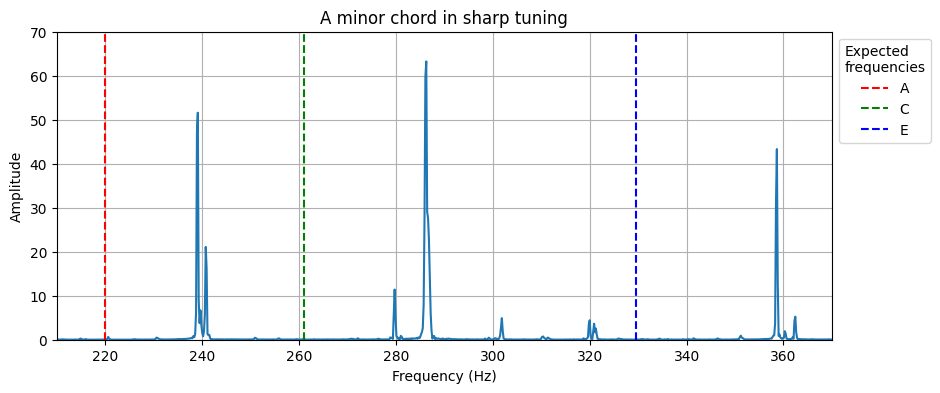

In [13]:
# visualise human tuning
plt = apply_fft(audio=naturalAminor, sampling_rate=sampling_rate)
plt.xlim(210, 370)
plt.ylim(0, 70)
plt.title("A minor chord in sharp tuning")
plt.axvline(x=220, color='r', linestyle='--', label="A")
plt.axvline(x=261, color='g', linestyle='--', label="C")
plt.axvline(x=329.63, color='b', linestyle='--', label="E")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Expected\nfrequencies")
plt.show()

<div style="background-color: #dd6108; color: #ffffff; padding: 10px;">
<h3>4. Human Sound Perception - the Log-Transformation
</div>

Speech consists of a series of sounds that are combined to form words. Next, we consider a vowel, which is called Schwa. Schwa is common vowel sound in German and English. It can be found in German words such as *b**e**reit* (ready) and *viel**e*** (many) or English words such as ***a**bout*.

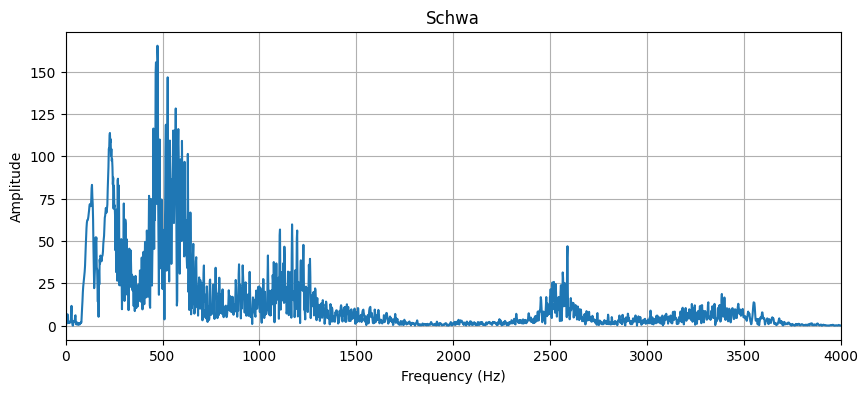

In [14]:
schwa, srSchwa= librosa.load("./data/Schwa.ogg.mp3", sr=None)

plt = apply_fft(audio=schwa, sampling_rate=srSchwa)
plt.xlim(0,4000)
plt.title("Schwa")
plt.show()

ipyd.Audio(data=schwa, rate=srSchwa)

When creating our acoustic features for training an ASR model, we make use of our knowledge about human perception. Two aspectes of human perception are especially relevant for ASR:

1. The full range of human hearing is from 20 Hz to 20,000 Hz but humans hear most accurately and sensitively in a narrower range from ~ 500 Hz to 4,000 Hz. Consequently, frequencies higher than 4,000 Hz can be ignored.
2. Humans are more sensitive to changes of soft sounds (low amplitudes) than to changes of loud sounds (high amplitude). For instance, the sound of two similar car engines appears to be louder for us than the sound of one of these engines, but we cannot hear a difference between the sound of 100 and 102 car engines.

Because of how humans perceive sound, we cut off our signal at 4,000 Hz (higher frequencies are irrelevant) and we log-transform the frequency components (emphasising changes on low amplitude areas).

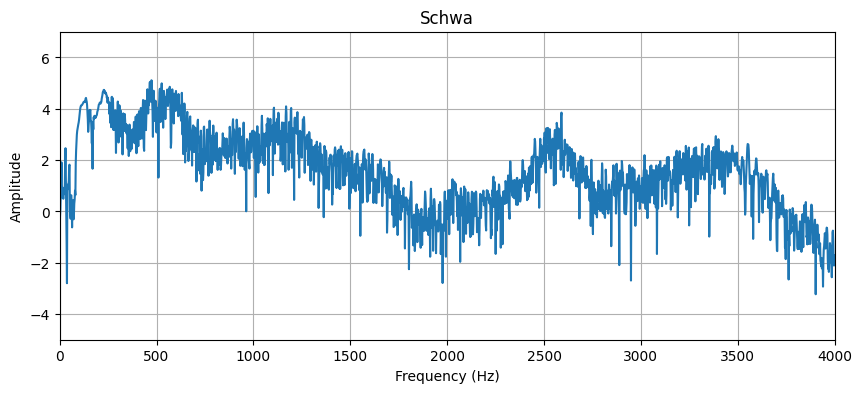

In [15]:
plt = apply_fft(audio=schwa, sampling_rate=srSchwa, logscale=True) # note that logscale has been set to True
plt.xlim(0,4000)
plt.ylim(-5, 7)
plt.title("Schwa")
plt.show()

A closer inspection of more speech sounds reveals that each sound has its own characteristic frequency spectrum.

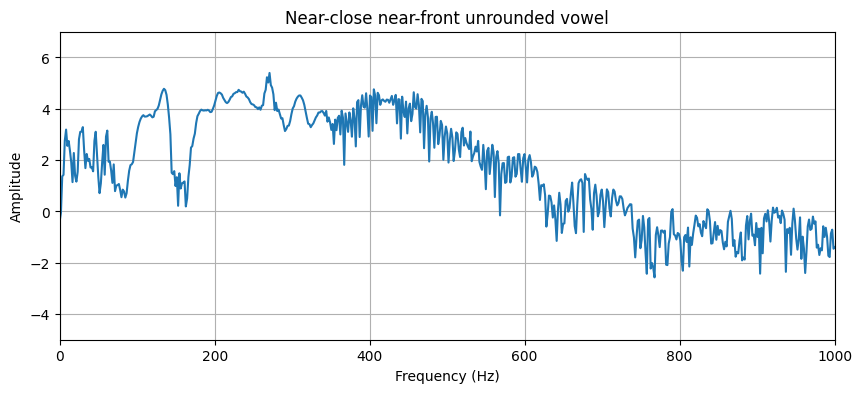

In [16]:
vowel1, srVowel1= librosa.load("./data/Near-close_near-front_unrounded_vowel.ogg.mp3", sr=None)

plt = apply_fft(audio=vowel1, sampling_rate=srVowel1, logscale=True)
plt.ylim(-5, 7)
plt.title("Near-close near-front unrounded vowel")
plt.show()

ipyd.Audio(data=vowel1, rate=srVowel1)

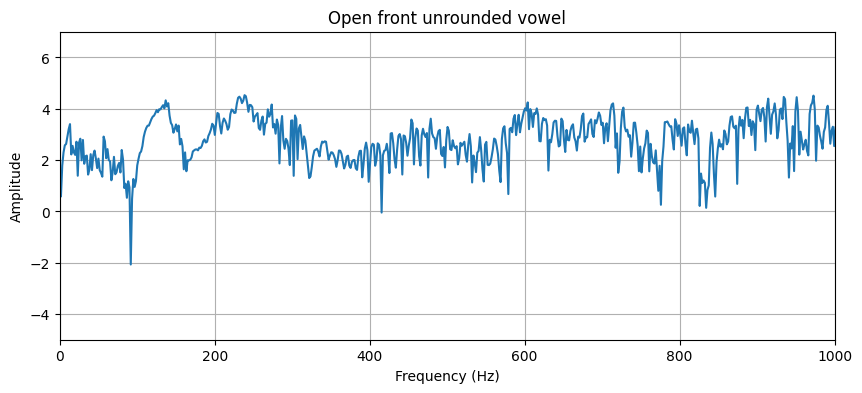

In [17]:
vowel2, srVowel2 = librosa.load("./data/Open_front_unrounded_vowel.ogg.mp3", sr=None)

plt = apply_fft(audio=vowel2, sampling_rate=srVowel2, logscale=True)
plt.ylim(-5, 7)
plt.title("Open front unrounded vowel")
plt.show()

ipyd.Audio(data=vowel2, rate=srVowel2)

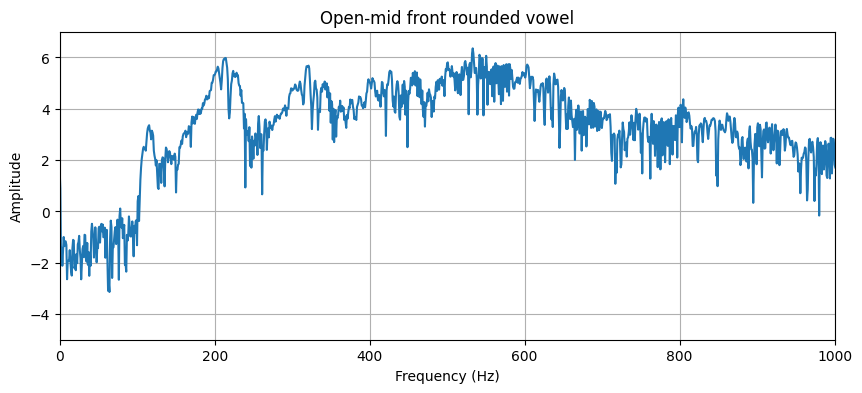

In [18]:
vowel3, srVowel3 = librosa.load("./data/Open-mid_front_rounded_vowel.ogg.mp3", sr=None)

plt = apply_fft(audio=vowel3, sampling_rate=srVowel3, logscale=True)
plt.ylim(-5, 7)
plt.title("Open-mid front rounded vowel")
plt.show()

ipyd.Audio(data=vowel3, rate=srVowel3)

<div style="background-color: #dd6108; color: #ffffff; padding: 10px;">
<h3>5. Short-Time Fourier Transform (STFT) - from Static to Sequence Analysis
</div>

While vowel sounds may be accurately discriminated based on their frequency spectra, even when analysed as a whole, longer sequences of speech (e.g., words, sentences) have to be analysed sequentially if we want to discriminate them. For instance, our features should not only capture that an audio sequence consists of frequency spectra corresponding to *a*, *e*, *l*, and *p*, but they have to capture information about order too. Otherwise, it would not be possible to discriminate between *leap*, *pale*, *peal*, and *plea*.

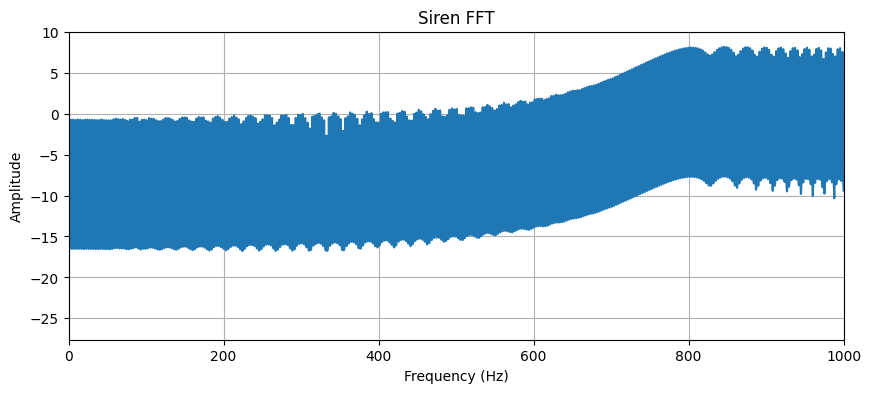

In [19]:
# First, we load an audio of a siren and inspect it
siren, srSiren= librosa.load("./data/siren.wav", sr=None)

# and for comparison, this is how it looks like when we just compute the FFT
plt = apply_fft(audio=siren, sampling_rate=srSiren, logscale=True)
plt.title("Siren FFT")
plt.show()

# It is advised to turn down the volume before playing this audio
ipyd.Audio(data=siren, rate=srSiren)

The STFT determines the frequency content of *local* sections of a signal as it changes over time. In practice, the procedure for computing STFTs is to divide a longer time signal into shorter segments of equal length and then compute the FFT separately on each shorter segment. Usually, for computing the STFT, the FFT is computed for the first 25 ms of the signal, then for 10-35 ms, then for 20-45 ms. The duration of each window is called the *window size* and the amount with which the window moves every step is called the *hop length*. Humans are assumed to have a window size of 10 ms. In digital signal processing, 25 ms is chosen because of a rich body of research concluding that 25 ms enable our models to yield the best performance.

In [21]:
# Take the first 25 ms of the siren audio
window_size = int(0.025 * srSiren)
window = siren[:window_size]

# Apply Hamming window and FFT
w = np.hamming(window_size)
window_fft = np.fft.rfft(window * w)
freqs = np.fft.rfftfreq(window_size, d=1/srSiren)

# Convert amplitude to dB
amplitude_db = librosa.amplitude_to_db(np.abs(window_fft), ref=np.max)

First, we apply the FFT to our first window.

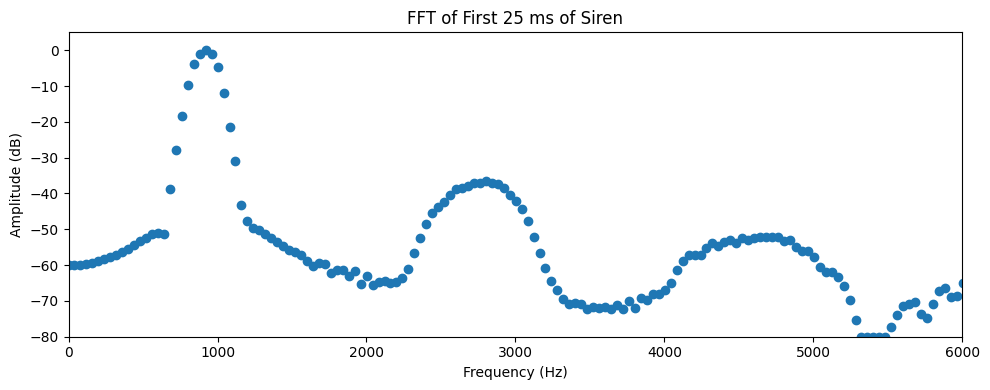

In [22]:
# Plot using the same colormap as the spectrogram ("magma")
plt.figure(figsize=(10, 4))
sc = plt.scatter(freqs, amplitude_db)
plt.ylim([amplitude_db.min(), amplitude_db.max() + 5])
plt.ylabel("Amplitude (dB)")
plt.title("FFT of First 25 ms of Siren")
plt.xlabel("Frequency (Hz)")
plt.xlim([0, 6000])
plt.tight_layout()
plt.show()

Second, instead of plotting amplitude on the y-axis, we visualise it with colours.

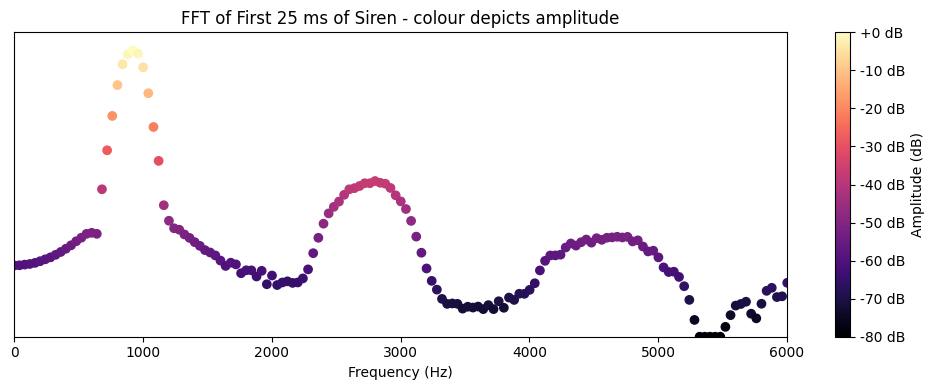

In [23]:
# Plot using the same colormap as the spectrogram ("magma")
plt.figure(figsize=(10, 4))
sc = plt.scatter(freqs, amplitude_db, c=amplitude_db, cmap='magma', marker='o')
plt.ylim([amplitude_db.min(), amplitude_db.max() + 5])
plt.ylabel("")
plt.yticks([])
plt.colorbar(sc, format="%+2.0f dB", label="Amplitude (dB)")
plt.title("FFT of First 25 ms of Siren - colour depicts amplitude")
plt.xlabel("Frequency (Hz)")
plt.xlim([0, 6000])
plt.tight_layout()
plt.show()

Third, the y-axis became obsolete and can be removed.

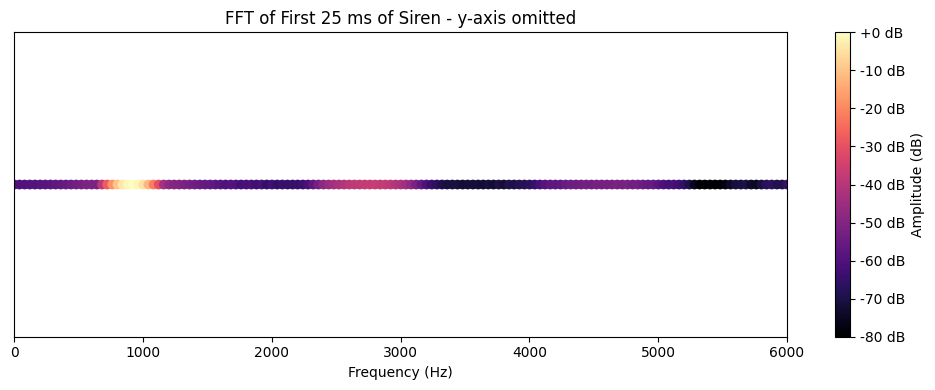

In [24]:
# plot without the y-axis
plt.figure(figsize=(10, 4))
sc = plt.scatter(freqs, np.zeros_like(freqs), c=amplitude_db, cmap='magma', marker='o')
plt.ylabel("")
plt.yticks([])
plt.colorbar(sc, format="%+2.0f dB", label="Amplitude (dB)")
plt.title("FFT of First 25 ms of Siren - y-axis omitted")
plt.xlabel("Frequency (Hz)")
plt.xlim([0, 6000])
plt.tight_layout()
plt.show()

Fourth, we flip the plot, because we want to plot the results from each window from left to right. 

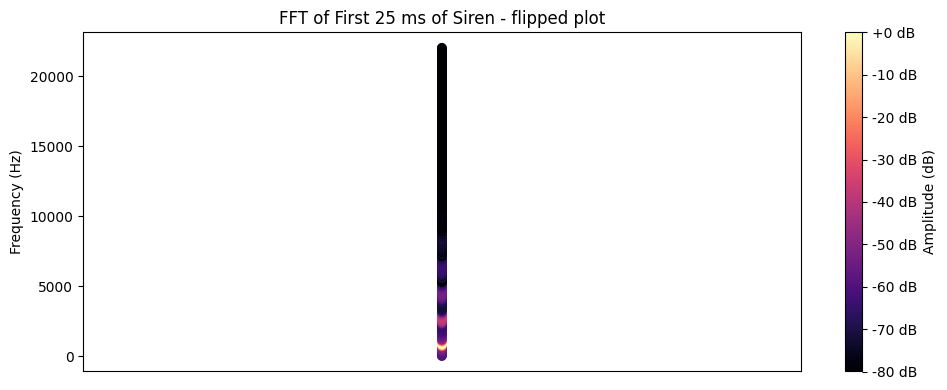

In [25]:
# plot without the y-axis
plt.figure(figsize=(10, 4))
sc = plt.scatter(np.zeros_like(freqs), freqs, c=amplitude_db, cmap='magma', marker='o')
plt.ylabel("Frequency (Hz)")
plt.colorbar(sc, format="%+2.0f dB", label="Amplitude (dB)")
plt.title("FFT of First 25 ms of Siren - flipped plot")
plt.xlabel("")
plt.xticks([])
plt.tight_layout()
plt.show()

If we create FFTs for moving windows (with colours instead of y-axis and flipped) and combine them, we will get a spectrogram.

(0.0, 6000.0)

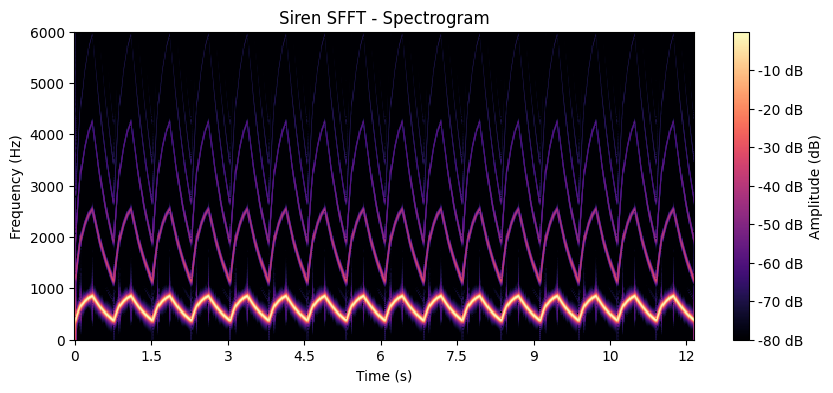

In [26]:
# Calculate window size and hop length
window_size = int(0.025 * srSiren)  # 25ms
hop_length = int(0.010 * srSiren)  # 10ms

# Compute STFT
stft = librosa.stft(siren, n_fft=window_size, hop_length=hop_length)

# Convert to amplitude and then dB
stft_amplitude = np.abs(stft)
stft_db = librosa.amplitude_to_db(stft_amplitude, ref=np.max)

# Plot the spectrogram
fig, ax = plt.subplots(figsize=(10, 4))
img = librosa.display.specshow(
    stft_db,
    x_axis='time',
    y_axis='hz',
    ax=ax,
    fmax=10000
)

# Add colorbar (legend for amplitude in dB)
cbar = fig.colorbar(img, ax=ax, format="%+2.0f dB")
cbar.set_label("Amplitude (dB)")

# Add labels and limits
plt.title("Siren SFFT - Spectrogram")
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim([0, 6000])


In this spectrogram, we can see the fundamental frequency (light yellowish) and its overtones (pink and purple). The fundamental frequency fluctuates between ~ 400 Hz (lower tones) and ~ 1000 Hz (higher tones), creating the typical siren sound. Colours indicate the amplitude of the different frequencies. Spectrograms are visual representations of how the the frequency content of an audio changes over time. One advantage of working with spectrograms is that they are readable. That is, experts can see from the spectrogram which word is spoken.

In [27]:
# Let's have a look at another example
count, srCount= librosa.load("./data/spanish_count.wav")
ipyd.Audio(data=count, rate=srCount)

(0.0, 8000.0)

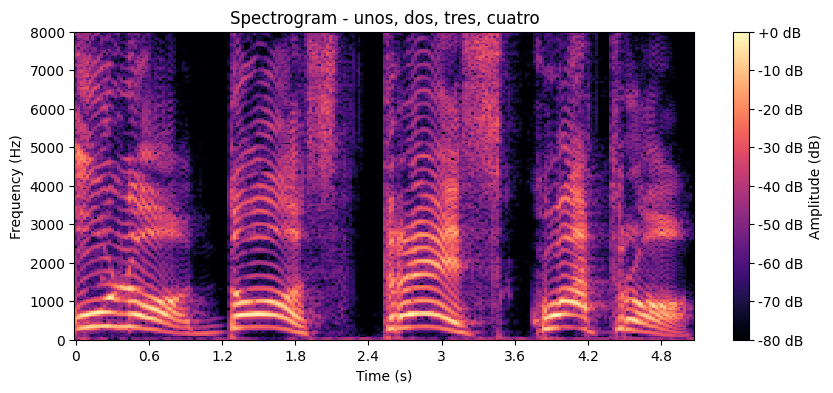

In [28]:
window_size = int(0.025 * srCount) # 25ms
hop_length = int(0.010 * srCount) # 10ms
stft = librosa.stft(count, n_fft=window_size, hop_length=hop_length)

# Convert to amplitude and then dB
stft_amplitude = np.abs(stft)
stft_db = librosa.amplitude_to_db(stft_amplitude, ref=np.max)

# Plot the spectrogram
fig, ax = plt.subplots(figsize=(10, 4))
img = librosa.display.specshow(
    stft_db,
    x_axis='time',
    y_axis='hz',
    ax=ax,
    fmax=10000
)

# Add colorbar (legend for amplitude in dB)
cbar = fig.colorbar(img, ax=ax, format="%+2.0f dB")
cbar.set_label("Amplitude (dB)")

# Add labels and limits
plt.title("Spectrogram - unos, dos, tres, cuatro")
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim([0, 8000])

In the spectrogram above, you see the high frequency content of "s" in "dos" and "tres" as well as the relative silence before the plosiv "t" in "cuatro", among others.

<div style="background-color: #dd6108; color: #ffffff; padding: 10px;">
<h3>6. Mel-scale spectrogram
</div>

Human perception is not linear. We're more sensitive to lower than to higher frequencies. For instance, we're more likely to perceive the difference between 300 and 310 Hz than between 3000 and 3010 Hz, which is illustrated by the following block:

In [29]:
sampling_rate = 16000
N = 2*sampling_rate # number of samples for given duration
n = np.arange(N) # sample indices
Hz300 = np.sin(2*np.pi*(300/sampling_rate)*n) # generate sine wave
display(ipyd.Audio(rate=sampling_rate, data=Hz300))
Hz310 = np.sin(2*np.pi*(310/sampling_rate)*n) # generate sine wave
display(ipyd.Audio(rate=sampling_rate, data=Hz310))
Hz2000 = np.sin(2*np.pi*(3000/sampling_rate)*n) # generate sine wave
display(ipyd.Audio(rate=sampling_rate, data=Hz2000))
Hz2010 = np.sin(2*np.pi*(3010/sampling_rate)*n) # generate sine wave
display(ipyd.Audio(rate=sampling_rate, data=Hz2010))

Because we want our model do have the same perception as humans (remember that humans are the most efficient speech recognisers that we know), we want a representation of the audio that emphasises changes in lower frequencies. This is achieved by the Mel-scale spectrogram.

In [30]:
# define functions to transform linear frequencies to mel frequencies and vice versa
def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700)
def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

The code block below demonstrates the mel scale. While we perceive the sampled sounds on the mel sccale (`mel_scale=True`) as having the same distance, this perception does not emerge when using linear frequencies (`mel_scale=False`).

In [32]:
sampling_rate = 16000
N = 0.5*sampling_rate # number of samples for given duration
n = np.arange(N) # sample indices

# decide which scale we want to use
mel_Scale = False
if mel_Scale:
    aFQ = mel_to_hz(300)
    bFQ = mel_to_hz(400)
    cFQ = mel_to_hz(500)
    dFQ = mel_to_hz(600)
else:
    aFQ = 300
    bFQ = 400
    cFQ = 500
    dFQ = 600

# create samples
aSample = np.sin(2*np.pi*(aFQ/sampling_rate)*n) # generate sine wave
bSample = np.sin(2*np.pi*(bFQ/sampling_rate)*n) # generate sine wave
cSample = np.sin(2*np.pi*(cFQ/sampling_rate)*n) # generate sine wave
dSample = np.sin(2*np.pi*(dFQ/sampling_rate)*n) # generate sine wave

# Combine samples into a single array and repeat three times
combinedSamples = np.tile(np.concatenate([aSample, bSample, cSample, dSample]), 3)
display(ipyd.Audio(rate=sampling_rate, data=combinedSamples))

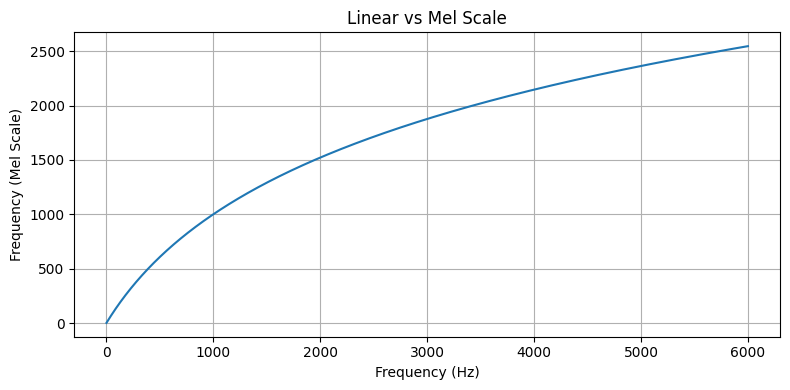

In [33]:
# X-axis: Hz values from 1 to 6000
hz_values = np.arange(1, 6001)  # inclusive range

# Y-axis: Mel values based on the Hz values
mel_values = np.array([hz_to_mel(hz) for hz in hz_values])

# Plot
plt.figure(figsize=(8, 4))
plt.plot(hz_values, mel_values)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency (Mel Scale)")
plt.title("Linear vs Mel Scale")
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="background-color: #dd6108; color: #ffffff; padding: 10px;">
<h3>6. Mel filterbanks
</div>

To capture how humans perceive pitch, we use Mel filterbanks, which are a series of overlapping bandpass filters. These filters are applied to the frequency spectrum of an audio signal, whereby each filter emphasises energy in a specific Mel frequency band. Mel frequency bands are distributed according to the Mel scale.


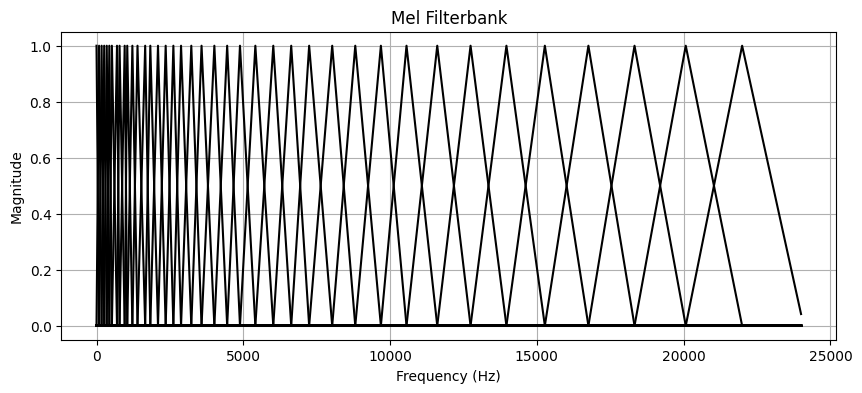

In [34]:
sample_rate = srSpectrogram
n_filters = 40
n_fft = window_size

# Convert the highest frequency to mel scale
high_freq_mel = hz_to_mel(sample_rate / 2)
    
# Create equally spaced points in mel scale
mel_points = np.linspace(0, high_freq_mel, n_filters + 2)
    
# Convert back to Hz
hz_points = mel_to_hz(mel_points)
    
# Convert to FFT bin numbers
bins = np.floor((n_fft + 1) * hz_points / sample_rate)
    
# Create the filterbank matrix
filterbank = np.zeros((n_filters, n_fft // 2 + 1)) 
for i in range(n_filters):
    for j in range(int(bins[i]), int(bins[i + 1])):
        filterbank[i, j] = (j - bins[i]) / (bins[i + 1] - bins[i])
    for j in range(int(bins[i + 1]), int(bins[i + 2])):
        filterbank[i, j] = (bins[i + 2] - j) / (bins[i + 2] - bins[i + 1])
    
# Visualise the filterbank (either for mel or linear scale)
plt.figure(figsize=(10, 4))
freq = np.linspace(0, sample_rate/2, n_fft//2 + 1)
mel_freq = hz_to_mel(freq)

# set scale to use for plotting
mel_Scale = False
if mel_Scale:
    plt_freq = mel_freq
else:
    plt_freq = freq
    
# Plot each filter
for i in range(filterbank.shape[0]):
    plt.plot(plt_freq, filterbank[i], color='black')
    
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Mel Filterbank')
plt.grid(True)
plt.show()

In [82]:
print(filterbank[0,0:10])
print(filterbank[1,0:10])
print(filterbank[2,0:10])

[0.  1.  0.5 0.  0.  0.  0.  0.  0.  0. ]
[0.  0.  0.5 1.  0.5 0.  0.  0.  0.  0. ]
[0.  0.  0.  0.  0.5 1.  0.5 0.  0.  0. ]


Now we can use this filters to capture the information of our FFT at frequencies corresponding to the mel filter bands. For doing so, for each window of our SFFT, we multiply each filter with this window's FFT and sum up the resulting values.

In [35]:
# get the first window
# window_size = int(0.025 * srSpectrogram) # 25ms
window1 = spectrogram[0:window_size]

# Apply FFT
N = len(window1)
w = np.hamming(N)
window1FFT = np.fft.fft(window1*w)
window1FFTpositives = np.abs(window1FFT[: N//2 + 1]) # keep only the positive frequencies

# multiply first filter with the first window and sum the result
band1 = filterbank[0] * window1FFTpositives
print(f"First filter times first window's FFT {band1[1:5]}")
print(f"Sum of the first filter {np.sum(band1)}")

First filter times first window's FFT [0. 0. 0. 0.]
Sum of the first filter 0.0007803615789336478


In [36]:
# Apply whole mel filterbank to window
mel_spec = filterbank @ window1FFTpositives
mel_spec

array([0.00078036, 0.00892259, 0.03851071, 0.05239393, 0.02625849,
       0.03711997, 0.03276769, 0.01494882, 0.03651579, 0.02698301,
       0.01807609, 0.01049677, 0.01925753, 0.01756384, 0.01147917,
       0.01206026, 0.02320216, 0.02969398, 0.01675904, 0.04167825,
       0.02348457, 0.02550672, 0.02208552, 0.01851125, 0.02802976,
       0.02954214, 0.01251347, 0.0304708 , 0.02148303, 0.04593265,
       0.06973286, 0.05717249, 0.09644346, 0.11390547, 0.1465631 ,
       0.11129931, 0.12111122, 0.1880608 , 0.22337559, 0.11970265])

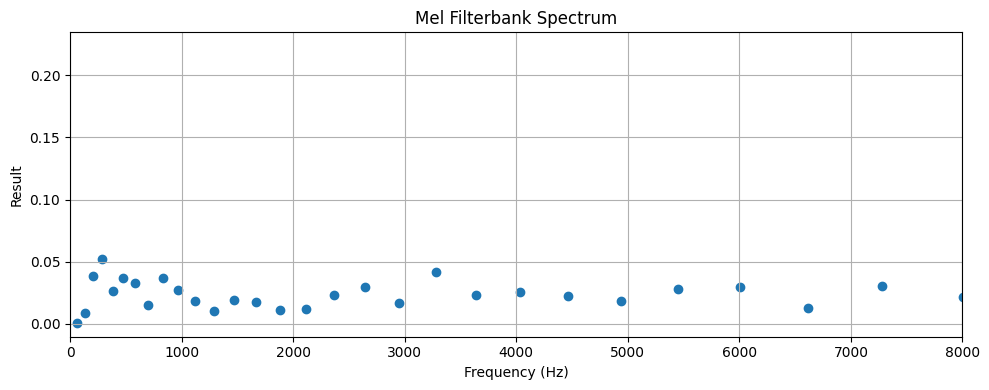

In [37]:
# visualise the filtered signal
mel_frequencies = hz_points[1:-1]  # shape: (n_filters,)

plt.figure(figsize=(10, 4))
plt.scatter(mel_frequencies, mel_spec)
plt.xlabel("Frequency (Hz)")
plt.xlim(0, 8000)
plt.ylabel("Result")
plt.title("Mel Filterbank Spectrum")
plt.grid(True)
plt.tight_layout()
plt.show()

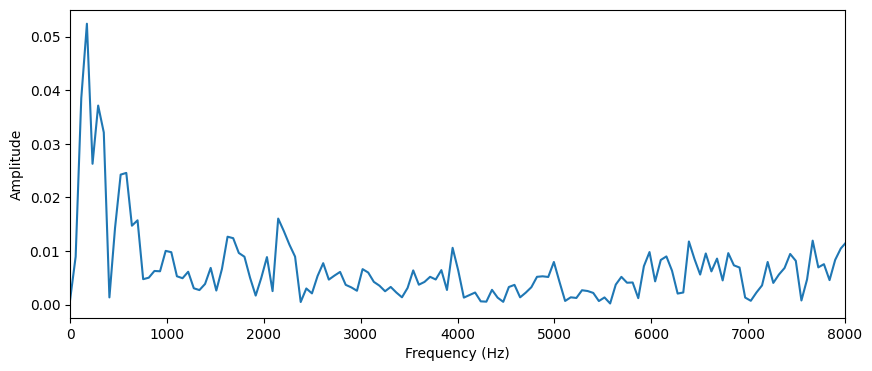

In [38]:
# comapre to the original FFT
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, sampling_rate*(N - 1)/N, N//2 + 1), window1FFTpositives)
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 8000)
plt.ylabel('Amplitude')
plt.show()

Comparing a simple spectrogram with the log-Mel spectrogram reveals some key differences.

1. The y-axis scale on log-Mel Spectrogram is on log scale and not linear.
2. The log-Mel Spectogram is reduced/compressed (i.e. lower resolution)

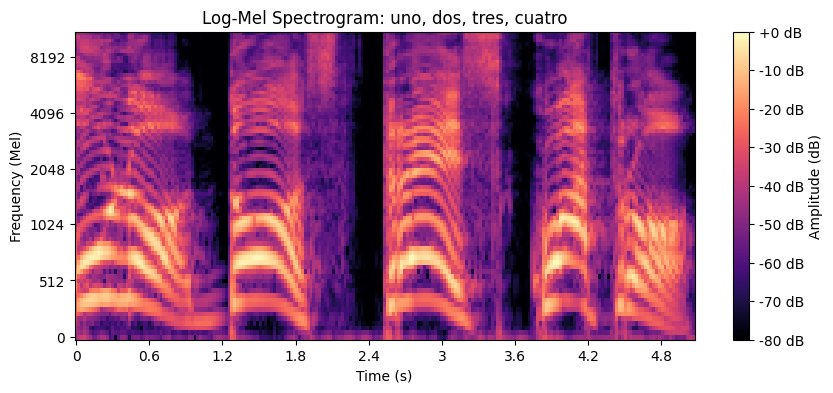

In [39]:
window_size = int(0.025 * srCount) # 25ms
hop_length = int(0.010 * srCount) # 10ms

# Mel-scale spectrogram (convert amplitude to dB)
mel_spectrogram = librosa.feature.melspectrogram(
    y=count/1.0, sr=srCount, n_mels=80, fmax=8000, n_fft=window_size, hop_length=hop_length
)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# plot log-mel spectrogram
fig, ax = plt.subplots(figsize=(10, 4))
img = librosa.display.specshow(
    log_mel_spectrogram, x_axis='time', y_axis='mel', cmap='magma'
)
plt.ylabel('Frequency (Mel)')
plt.xlabel('Time (s)')
cbar = fig.colorbar(img, format="%+2.0f dB")
cbar.set_label("Amplitude (dB)")
plt.title("Log-Mel Spectrogram: uno, dos, tres, cuatro")
plt.show()

<div style="background-color: #dd6108; color: #ffffff; padding: 10px;">
<h3>7. Mel-Frequency Cepstral Coefficient (MFCC)
</div>

Mel-Frequency Cepstral Coefficients (MFCCs) are a compact representation of the spectral properties of audio, which is derived by first converting the audio signal into a log Mel-scale spectrogram. Further compression and decorrelation with a Discrete Cosine Transform (DCT) is applied across the Mel filterbank energies in each time frame. This concentrates the most relevant information into the first few coefficients, reducing redundancy and dimensionality. MFCCs are particularly useful in traditional machine learning pipelines, such as Hidden Markov Models (HMMs), where lower-dimensional, decorrelated features can improve model efficiency and performance compared to raw or log Mel-spectrograms. However, MFCCs are not 'readable' anymore.

Text(0.5, 0, 'Time (s)')

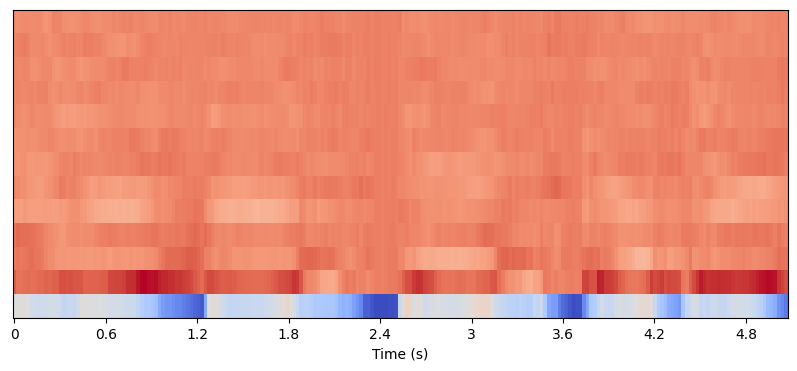

In [109]:
# Mel-scale spectrogram
mfccs = librosa.feature.mfcc(
    y=count/1.0, sr=srCount, n_mfcc=13, n_mels=80, n_fft=window_size, hop_length=hop_length
)

# plot log-mel spectrogram
fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.specshow(
    mfccs, x_axis='time'
)
plt.xlabel('Time (s)')

<div style="background-color: #dd6108; color: #ffffff; padding: 10px;">
<h3>8. Summary

Using the MFCCs or log Mel-scale spectrogram can represent the frequency content of a sequential signal as it changes over time. These representations take the form of vectors with as many dimensions as the number of used Mel filterbanks. Mel filterbanks have multiple advantages:

- Emphasis of pitch differences for lower frequencies (more filters for lower frequencies than for higher frequencies)
- Reduction of features (typically 40 to 80 features for each window instead of more than thousand frequency bins of raw FFTs)
- Increased noise robustness because of averaging FFT magnitudes over frequency bands so that local noise is smoothed out